<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Identifying Pneumothorax in Chest X-rays
In this example notebook we are going to bring together several of the things we have learned about related to image classification and focus on two aspects that are critical for modeling real-world problems:  
- Creating a custom Dataset in PyTorch to load images and labels in non-standard formats  
- Loading and fine-tuning a pretrained model on a new task  

Our objective in this exercise will be to identify [pneumothorax](https://en.wikipedia.org/wiki/Pneumothorax) from chest X-ray images. 

The data we will be working with is a set of chest X-rays in the DICOM (Digital Imaging and Communications in Medicine) format.  DICOM is a standard for medical images (X-rays, MRI, CT) which allows information to be exchanged between different imaging equipment and hospitals.  DICOM files include both a header and image data and have the file extension `.dcm`.  The file header can contain equipment information, patient information, study information, etc.

The particular dataset we will work with is a subset of 250 DICOM files from the [NIH Chest X-ray Dataset](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7165201/), which includes 111,000 total chest X-ray images and associated labels of various diseases.  Of these a subset of 15302 was taken to include a mix of images labeled pneumothorax or normal.  The 250 we will use representes a small fraction of this subset.

**Notes:**
- This notebook is recommended to be run on GPU but can be run on CPU in 10-15 minutes for demo training  
- Actual training should be run for many more epochs and done on GPU

**References:**
- This notebook is inspired by the example in the [fast.ai documentation](https://docs.fast.ai/tutorial.medical_imaging.html).  Check out their tutorial if you'd like to use the fast.ai framework rather than pure PyTorch  
- Read the [original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7165201/) by Filice et al. about this dataset
- This example uses a ResNet18 architecture pre-trained on ImageNet.  Read the original [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)


In [ ]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI540-Deep-Learning-Applications" # Enter repo name
git_path = 'https://github.com/AIPI540/AIPI540-Deep-Learning-Applications.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Change working directory to location of notebook
notebook_dir = '2_computer_vision/CNNs'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [1]:
import os
import urllib.request
import tarfile
import copy
import time
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pydicom
import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  1.10.1


## Data preparation
### Download data

In [2]:
# Download the data
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('data/siim_small'):
    url = 'https://s3.amazonaws.com/fast-ai-imagelocal/siim_small.tgz'
    urllib.request.urlretrieve(url,filename='data/siim_small.tgz')
    file = tarfile.open('data/siim_small.tgz')
    file.extractall('data')
    file.close()

### Convert labels to numeric
Since PyTorch cannot work with string labels, we need to set up a mapping dictionary to convert them to integers.

In [67]:
classes = ['No Pneumothorax','Pneumothorax']
idx_to_class = {i:j for i,j in enumerate(classes)}
class_to_idx = {v:k for k,v in idx_to_class.items()}

### Create PyTorch Datasets from data and load DataLoaders
We'll first need to create a Dataset from our images and labels before we can load it into a DataLoader.  If you examine the structure of your data directory that you just downloaded, you will see that the images are actually labeled by the folder in which they are located: "No Pneumothorax" and "Pneumothorax".  However, we also have the labels contained in a file "labels.csv" and so we are going to use this to demonstrate the creation of a custom Dataset in PyTorch.  Additionally, since our data files are DICOMs not image files, we will not be able to use the out-of-the-box PyTorch `Imagefolder()` to put them in a Dataset.

In [68]:
class DicomDataset(Dataset):
    '''
    Custom PyTorch Dataset for image classification
    Must contain 3 parts: __init__, __len__ and __getitem__
    '''

    def __init__(self, csv_path: str, data_dir: str, class_mapper: dict, transform=None):
        '''
        Args:
            csv_path (string): Path to the csv containing the image names and corresponding labels
            data_dir (string): Path to directory containing the images
            class_mapper (dict): Dictionary mapping string labels to numeric labels
            transform (callable,optional): Optional transform to be applied to images
        '''
        self.labels_df = pd.read_csv(csv_path)
        self.transform = transform
        self.data_dir = data_dir
        self.classes = self.labels_df.iloc[:,1].unique()
        self.classmapper = class_mapper

    def __len__(self):
        '''Returns the number of images in the Dataset'''
        return len(self.labels_df)

    def __getitem__(self, idx):
        '''
        Returns the image and corresponding label for an input index
        Used by PyTorch to create the iterable DataLoader

        Args:
            idx (integer): index value for which to get image and label
        '''

        # Load the image
        img_path = os.path.join(self.data_dir,
                                self.labels_df.iloc[idx, 0])
        
        # For a normal image file (jpg,png) use the below
        # image = cv2.imread(img_path) # Use this for normal color images
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Use this for color images to rearrange channels BGR -> RGB

        # Since we are dealing with DICOM files we instead load images using pydicom:
        image = pydicom.dcmread(img_path) # load the dicom file
        image = image.pixel_array # convert dicom pixel data to numpy array
        image = Image.fromarray(image) # convert numpy array to PIL image

        # Load the label
        label = self.labels_df.iloc[idx, 1]
        label = self.classmapper[label]

        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

We also need to set up our transforms for the dataset, which will be applied to the images when they are loaded into our XrayDataset we created above.

The transforms we apply below do the following:  
- `Resize(224)`: resize to 224 to be consistent with model pre-trained on ImageNet (we do not want to do random cropping in this case since we want to preserve the lungs in the images)  
- `ToTensor()`: convert pixel values to a Tensor and scale to range [0,1]  
- `Normalize()`: standardize pixel values to have approx. mean=0 and std=1 (not required but helps model train better).  Note: we generally want to standardize using the mean and std of the distribution of the images in our training set.  However, since in this case we do not know what they are and it requires a bit of work to calculate them, we will just simplify and use 0.5,0.5

In [69]:
data_transform = transforms.Compose([transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])])

Now we are ready to create our Dataset using our custom class, and then use it to load the data into a DataLoader.

In [70]:
data_dir = 'data/siim_small'


# Create Dataset
train_dataset = DicomDataset(csv_path=os.path.join(data_dir,'labels.csv'),
                            data_dir=data_dir,
                            class_mapper=class_to_idx,
                            transform = data_transform)

# Create DataLoader
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=0)

# Store size of training set
dataset_size = len(train_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([8, 1, 224, 224])


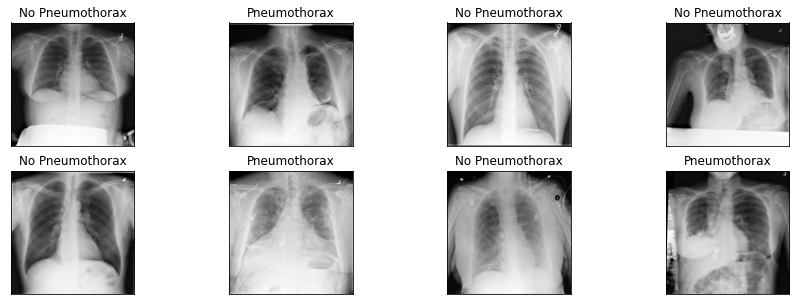

In [71]:
# Get next batch of training images
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy() # Convert images to numpy for display
labels = labels.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(idx_to_class[labels[idx]])

As we see above, the inputs in a PyTorch DataLoader are of shape [N,C,H,W) where:  
- N = batch size  
- C = number of channels (1 for grayscale, 3 for RGB color)  
- H = image height  
- W = image width

### Define our model architecture
We will used a pre-trained ResNet18 model in this example.  However, we will need to make a couple changes to it:  
- Since we have 2 output classes instead of 1000 (the ImageNet default), we need to replace the final fully connected layer in the network with a new layer that has 2 output units (not 1000)  
- Since our images are black/white, we have a single input channel rather than 3.  Therefore we will replace the first layer in the network with a new convolutional layer that has `in_channels = 1`

In [72]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was originally trained on color (3 input channels)
in_channels = 1
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (2)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 2)

# Display a summary of the layers of the model and output shape after each layer
summary(model_resnet,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           3,136
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]          36,864
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
       BasicBlock-11            [8, 64, 56, 56]               0
           Conv2d-12            [8, 64, 56, 56]          36,864
      BatchNorm2d-13            [8, 64, 56, 56]             128
             ReLU-14            [8, 64,

### Train the model

In [73]:
def train_model(model,criterion,optimizer,loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        running_corrects = 0
        
        for i, data in enumerate(loader):
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item() * inputs.size(0)
            # Track number of correct predictions
            running_corrects += torch.sum(preds == labels.data)
            
        # Calculate and display average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        loss_over_time.append(epoch_loss)

    return loss_over_time

Loss: 0.6350 Acc: 0.7080
Loss: 0.6249 Acc: 0.7160
Loss: 0.6219 Acc: 0.7200
Loss: 0.6011 Acc: 0.7360
Loss: 0.6000 Acc: 0.7080
Loss: 0.5799 Acc: 0.7240
Loss: 0.5941 Acc: 0.7240
Loss: 0.5910 Acc: 0.7120
Loss: 0.5829 Acc: 0.7280
Loss: 0.5523 Acc: 0.7680
Loss: 0.5662 Acc: 0.7320
Loss: 0.5828 Acc: 0.7360
Loss: 0.5448 Acc: 0.7600
Loss: 0.5604 Acc: 0.7680
Loss: 0.5462 Acc: 0.7480
Loss: 0.5418 Acc: 0.7640
Loss: 0.5257 Acc: 0.7960
Loss: 0.5170 Acc: 0.7560
Loss: 0.5142 Acc: 0.7760
Loss: 0.5416 Acc: 0.7720


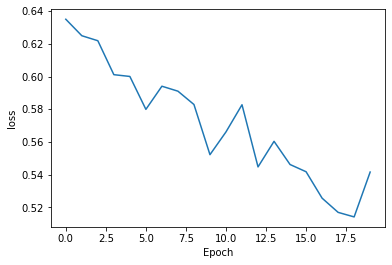

In [75]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train the model
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model(model_resnet,criterion,optimizer,train_loader,n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

### Visualize results

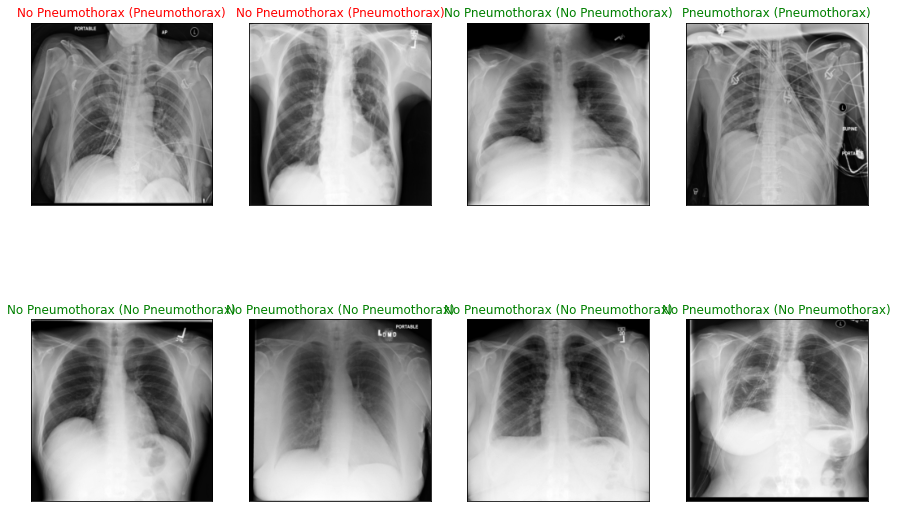

In [78]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(train_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(model_resnet,train_loader,device)